# «Метанпромбанк» — Анализ оттока клиентов

# Заказчик - отдел маркетинга "Метанпромбанк"

### Цель анализа - определить степень оттока клиентов из банка, выявить возможные причины, взаимосвязи оттока. 
 

### Задачи:
1. Предобработка данных. Загрузка основных библиотек, просмотр общей информации в таблице, проверить формат данных, при необходимости привести к нужному регистру и формату, проверить на наличие пропусков, просмотреть дубликаты(явные/неявные).
2. Исследовательский анализ EDA. Проверить корреляцию основных клиентских качеств и признака оттока, посмотреть есть ли признаки которые могли повлиять на отток клиента. Построить портрет клиента
3. Проверка гипотез: 
- Уровень дохода влияет на отток
- В городе 'A' отток  больше чем в городе 'B'
- Наличие(отсутствие) кредитной карты влияет на отток
4. Провести сегментацию клиентов. 
5. На основе проведенных ранее анализов, предположить причину оттока клиентов. Дать рекомендации отделу маркетинга по снижению оттока, отдельно по каждому выделенному сегменту.

## Шаг 1. Изучим представленные данные

In [1]:
!pip install phik

In [2]:
#импотритруем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly import graph_objects as go
from scipy import stats
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import math

import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix



In [3]:
#прочитаем файл
try:
    data=pd.read_csv('bank_scrooge.csv')
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Нам необходимо проанализировать таблицу, которая состоит из 12 колонок и 10000 строк, для начала приведем название колонок к нижнему регистру

## Шаг 2. Подготовим данные

In [6]:
#привидем название всех столбцов к нижнему регистру
data.apply(lambda x: x.astype(str).str.lower())
data.rename(columns=lambda x: x.lower(), inplace=True)

In [7]:
#приведем столбец userid к правильному формату
data.rename(columns={'userid': 'user_id'}, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [9]:
#проверим на наличие пропусков
data.isna().sum()

user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

В таблице имеються пропуски в столбце 'age' и 'balance', рассмотрим харрактер пропусков

In [10]:
distplot_columns = ['score', 'age', 'est_salary', 'balance']
for column in distplot_columns:
    unique_values = data[column].unique()
    print(f"Уникальные значения в столбце {column}:\n{unique_values}\n")

Уникальные значения в столбце score:
[ 850.  861.  892.  866.  730.  856.  807.  825.  923.  906.  927.  921.
  845.  837.  815.  731.  829.  793.  876.  922.  772.  896.  871.  732.
  898.  806.  766.  776.  868.  946.  828.  786.  944.  863.  822.  794.
  924.  811.  814.  956.  935.  826.  849.  901.  893.  792.  888.  831.
  748.  820.  860.  914.  930.  948.  789.  737.  812.  933.  809.  749.
  873.  859.  950.  937.  835.  768.  767.  785.  846.  750.  816.  894.
  891.  788.  758.  787.  821.  855.  779.  791.  838.  971.  797.  841.
  915.  985.  870.  897.  763.  774.  686. 1000.  875.  819.  869.  854.
  810.  761.  802.  958.  917.  745.  736.  908.  928.  884.  853.  780.
  726.  881.  975.  852.  965.  899.  890.  836.  818.  880.  795.  916.
  775.  902.  918.  842.  771.  895.  801.  721.  966.  804.  885.  986.
  753.  832.  979.  798.  754.  756.  823.  658.  734.  954.  827.  929.
  760.  688.  659.  817.  718.  705.  920.  652.  649.  862.  770.  824.
  934.  952.  

In [11]:
distplot_columns = ['city', 'gender', 'last_activity', 'credit_card', 'churn', 'equity', 'products']
for column in distplot_columns:
    values = data[column].value_counts()
    print(f"Уникальные значения в столбце {column}:\n{values}\n")

Уникальные значения в столбце city:
Ярославль    5888
Рыбинск      2695
Ростов       1417
Name: city, dtype: int64

Уникальные значения в столбце gender:
М    5005
Ж    4995
Name: gender, dtype: int64

Уникальные значения в столбце last_activity:
1    5235
0    4765
Name: last_activity, dtype: int64

Уникальные значения в столбце credit_card:
1    6804
0    3196
Name: credit_card, dtype: int64

Уникальные значения в столбце churn:
0    8180
1    1820
Name: churn, dtype: int64

Уникальные значения в столбце equity:
0    2592
5    1918
4    1850
3    1543
2    1052
1     774
6     161
7      80
8      17
9      13
Name: equity, dtype: int64

Уникальные значения в столбце products:
2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: products, dtype: int64



Рассмотрев уникальные значения, видно что есть выбросы в данных, в столбце 'equity' есть данные о наличие 7,8,9 объектов недвижимости, в столбце 'products' у 1 клиента данные о продукте отображаются 0, скорей всего либо клиента еще полностью не оформили, либо ошибка в данных, удалим эти строки.

In [12]:
# Создаем фильтр для выбросов
outliers_filter = (data['products'] < 1) | (data['equity'] >6)

# Удаляем строки с выбросами из датафрейма
data = data[~outliers_filter]

# Проверяем, что выбросы удалены
print("Количество строк после удаления выбросов:", len(data))

Количество строк после удаления выбросов: 9889


In [13]:
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,9889.000000,9889.000000,9863.000000,9889.000000,7.595000e+03,9889.000000,9889.000000,9889.000000,9.889000e+03,9889.000000
mean,171808.637982,848.412782,42.738822,2.574578,8.264530e+05,1.865305,0.681666,0.522601,1.482120e+05,0.178886
std,33687.890985,65.586125,12.176652,1.925421,1.990023e+06,0.788942,0.465853,0.499514,1.396552e+05,0.383276
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142811.000000,801.000000,33.000000,0.000000,2.939116e+05,1.000000,0.000000,0.000000,7.538400e+04,0.000000
50%,172716.000000,852.000000,40.000000,3.000000,5.195924e+05,2.000000,1.000000,1.000000,1.198551e+05,0.000000
75%,201261.000000,900.000000,51.000000,4.000000,9.816121e+05,2.000000,1.000000,1.000000,1.748915e+05,0.000000
max,229145.000000,1000.000000,86.000000,6.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [14]:
#Проверим DF на дубликаты
data.duplicated().sum()


0

В DF явные дубликаты не выявлены

In [15]:
#рассмотрим столбце 'user_id' на наличие дубликатов
duplicate_count = data['user_id'].duplicated().sum()
print("Количество дубликатов в столбце 'user_id':", duplicate_count)

Количество дубликатов в столбце 'user_id': 70


In [16]:
duplicates = data[data.duplicated(subset=['user_id'], keep=False)]
# Вывод различий между дублирующими строками
for user_id, group in duplicates.groupby('user_id'):
    display(f"User ID: {user_id}")
    display(group)
    display("\n")

'User ID: 116540'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0


'\n'

'User ID: 117943'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0


'\n'

'User ID: 120258'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0


'\n'

'User ID: 123461'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0


'\n'

'User ID: 124450'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


'\n'

'User ID: 126368'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4850,126368,909.0,Ярославль,Ж,30.0,4,1322623.29,2,0,1,140675.66,1
5420,126368,832.0,Рыбинск,Ж,33.0,0,NaN,1,0,0,118465.34,0


'\n'

'User ID: 127440'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4443,127440,846.0,Рыбинск,М,66.0,1,57405.67,2,0,1,17831.63,0
8785,127440,663.0,Ярославль,М,NaN,0,NaN,1,1,1,117197.56,0


'\n'

'User ID: 129785'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3988,129785,904.0,Рыбинск,М,33.0,5,2427737.6,3,0,1,188856.75,1
9504,129785,949.0,Ярославль,М,43.0,0,NaN,1,1,1,166845.37,0


'\n'

'User ID: 131419'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
904,131419,934.0,Ярославль,М,35.0,5,2348335.95,2,0,0,217105.13,1
2138,131419,739.0,Рыбинск,Ж,37.0,3,1307941.65,3,0,0,103867.47,0


'\n'

'User ID: 140377'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1608,140377,802.0,Ярославль,М,26.0,3,539863.29,4,1,1,112167.83,1
7487,140377,930.0,Рыбинск,Ж,34.0,5,1123967.02,1,1,1,148336.26,0


'\n'

'User ID: 140934'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4212,140934,919.0,Ярославль,Ж,29.0,4,603946.18,3,0,1,158438.79,0
9819,140934,832.0,Рыбинск,Ж,NaN,3,385763.16,2,0,1,59651.35,0


'\n'

'User ID: 141265'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2276,141265,858.0,Ярославль,М,37.0,4,471599.16,2,1,1,148806.88,1
5569,141265,811.0,Рыбинск,Ж,33.0,3,1044316.88,2,1,0,46055.32,0


'\n'

'User ID: 141945'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4343,141945,929.0,Рыбинск,М,33.0,0,NaN,1,1,0,381868.89,0
9457,141945,929.0,Ярославль,М,NaN,0,NaN,1,1,0,381868.89,0


'\n'

'User ID: 143592'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5369,143592,885.0,Рыбинск,Ж,56.0,4,1201087.46,2,1,1,88223.89,1
5557,143592,764.0,Ярославль,Ж,68.0,3,508919.15,2,0,1,71211.66,0


'\n'

'User ID: 148826'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5252,148826,895.0,Ярославль,М,32.0,5,1470273.14,2,0,0,118058.52,1
8364,148826,909.0,Рыбинск,Ж,32.0,0,NaN,3,1,0,28843.54,0


'\n'

'User ID: 149365'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
946,149365,877.0,Ярославль,М,41.0,5,819182.01,2,0,0,212316.47,1
8272,149365,793.0,Рыбинск,Ж,61.0,0,476496.99,2,1,1,46147.06,0


'\n'

'User ID: 150667'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2439,150667,813.0,Рыбинск,Ж,44.0,0,62504.47,4,1,0,152393.79,1
9267,150667,931.0,Ярославль,М,41.0,0,NaN,1,0,0,261904.44,0


'\n'

'User ID: 151662'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3683,151662,960.0,Ярославль,Ж,37.0,4,2527032.7,4,1,0,231648.50,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0


'\n'

'User ID: 152479'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
690,152479,768.0,Рыбинск,Ж,42.0,0,126787.79,4,1,1,143233.23,1
5705,152479,723.0,Ярославль,Ж,22.0,0,NaN,1,1,0,83955.65,0


'\n'

'User ID: 155765'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.0,Ярославль,М,30.0,5,1036114.5,5,1,1,150744.5,1
5197,155765,923.0,Рыбинск,М,30.0,0,NaN,1,1,1,120296.6,0


'\n'

'User ID: 155872'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1080,155872,896.0,Ярославль,М,36.0,3,1113656.92,3,0,1,291176.85,1
9363,155872,714.0,Рыбинск,Ж,29.0,0,NaN,1,1,0,118052.84,0


'\n'

'User ID: 160075'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3936,160075,899.0,Ярославль,М,34.0,4,1647814.67,4,1,0,151888.42,1
9508,160075,824.0,Рыбинск,Ж,57.0,3,355047.33,2,0,0,64351.81,0


'\n'

'User ID: 162053'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5629,162053,921.0,Рыбинск,М,33.0,3,857011.13,2,1,1,113512.57,1
8733,162053,786.0,Ярославль,М,29.0,4,205824.97,3,1,0,121371.73,0


'\n'

'User ID: 163207'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3564,163207,853.0,Рыбинск,М,42.0,4,543839.62,1,1,1,105281.97,1
6786,163207,838.0,Ярославль,Ж,42.0,4,652776.60,2,1,1,97545.36,0


'\n'

'User ID: 163657'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
6670,163657,903.0,Рыбинск,М,45.0,4,1343339.70,4,0,1,83741.65,0
9667,163657,849.0,Ярославль,М,NaN,4,1254013.85,2,1,1,119106.67,0


'\n'

'User ID: 164676'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
7271,164676,790.0,Рыбинск,Ж,77.0,1,111202.01,1,1,0,32835.45,0


'\n'

'User ID: 168998'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5020,168998,886.0,Ярославль,Ж,35.0,4,394780.61,2,1,1,510577.10,1
9785,168998,895.0,Рыбинск,М,44.0,0,282653.53,3,0,0,255296.47,0


'\n'

'User ID: 170312'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
790,170312,901.0,Ярославль,М,33.0,4,3276783.93,3,0,1,358700.96,1
3039,170312,813.0,Рыбинск,Ж,47.0,3,370027.67,2,0,0,129835.56,0


'\n'

'User ID: 171751'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4587,171751,874.0,Рыбинск,Ж,26.0,5,292054.42,2,0,1,20528.56,1
9653,171751,862.0,Ярославль,М,42.0,4,481992.19,2,1,0,71816.86,0


'\n'

'User ID: 172142'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2941,172142,896.0,Ярославль,Ж,30.0,4,1009073.14,4,1,0,70866.29,1
6756,172142,751.0,Рыбинск,Ж,69.0,3,396568.03,2,0,1,45608.45,0


'\n'

'User ID: 181526'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2989,181526,918.0,Ярославль,Ж,37.0,5,1366382.35,4,1,1,97932.95,1
8705,181526,895.0,Рыбинск,М,29.0,0,NaN,1,1,1,124786.53,0


'\n'

'User ID: 185748'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
3106,185748,912.0,Ярославль,Ж,47.0,5,1598218.98,2,0,0,180256.98,0


'\n'

'User ID: 185829'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3668,185829,925.0,Рыбинск,М,40.0,0,NaN,1,1,0,228305.64,0
9632,185829,927.0,Ярославль,М,NaN,0,NaN,1,1,0,231254.86,0


'\n'

'User ID: 187459'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4720,187459,895.0,Ярославль,М,48.0,0,NaN,1,1,0,180887.50,0
9380,187459,894.0,Рыбинск,М,NaN,0,NaN,1,1,0,178012.28,0


'\n'

'User ID: 187635'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
918,187635,918.0,Ярославль,Ж,44.0,0,NaN,1,1,1,162497.52,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0


'\n'

'User ID: 188957'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5454,188957,853.0,Ярославль,М,35.0,1,374959.62,2,1,1,197600.97,1
6005,188957,882.0,Рыбинск,Ж,64.0,3,893392.91,3,1,0,69622.58,0


'\n'

'User ID: 190253'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0


'\n'

'User ID: 191520'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3859,191520,773.0,Рыбинск,М,36.0,3,1219918.08,4,1,1,119933.13,1
7931,191520,767.0,Ярославль,М,45.0,0,NaN,1,1,1,880005.05,0


'\n'

'User ID: 195884'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2226,195884,906.0,Ярославль,М,49.0,6,1354552.83,2,0,0,270678.42,1
9659,195884,767.0,Рыбинск,Ж,45.0,1,335652.56,3,1,1,100197.67,0


'\n'

'User ID: 197364'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
4870,197364,889.0,Ярославль,М,33.0,0,NaN,2,1,1,96173.48,0


'\n'

'User ID: 198635'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1181,198635,896.0,Рыбинск,Ж,32.0,0,NaN,1,1,1,170866.01,0
8015,198635,670.0,Ярославль,Ж,NaN,0,NaN,1,1,1,168699.33,0


'\n'

'User ID: 199312'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2499,199312,948.0,Ярославль,М,41.0,5,3095721.85,4,1,1,307234.69,1
8822,199312,911.0,Рыбинск,Ж,43.0,0,NaN,2,1,1,152189.72,0


'\n'

'User ID: 202983'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8897,202983,941.0,Ярославль,Ж,39.0,0,NaN,1,0,1,159348.84,0
9301,202983,942.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,163804.73,0


'\n'

'User ID: 206759'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
5889,206759,917.0,Ярославль,М,22.0,0,NaN,1,1,0,70617.52,0
8385,206759,915.0,Рыбинск,М,NaN,0,NaN,1,1,0,71179.53,0


'\n'

'User ID: 208081'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1513,208081,873.0,Ярославль,М,31.0,2,232814.75,2,1,1,122505.86,1
2998,208081,821.0,Рыбинск,Ж,62.0,3,493608.26,2,1,1,33491.45,0


'\n'

'User ID: 208738'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1580,208738,897.0,Рыбинск,Ж,45.0,5,859018.19,2,1,1,145510.08,1
5840,208738,839.0,Ярославль,М,60.0,5,1102438.37,2,0,1,116500.81,0


'\n'

'User ID: 208815'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3350,208815,877.0,Рыбинск,М,25.0,4,239421.18,1,1,1,48638.00,1
5570,208815,773.0,Ярославль,М,39.0,4,288110.09,2,1,0,56971.91,0


'\n'

'User ID: 210135'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3230,210135,974.0,Ярославль,Ж,50.0,5,5680148.93,4,1,1,338471.66,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0


'\n'

'User ID: 210627'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7453,210627,864.0,Ярославль,Ж,38.0,4,1527225.32,4,1,1,162999.17,1
8521,210627,804.0,Рыбинск,М,30.0,2,347818.88,3,1,0,129015.25,0


'\n'

'User ID: 210662'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
869,210662,962.0,Ярославль,Ж,54.0,5,5069231.39,1,1,1,955144.85,1
1837,210662,896.0,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0


'\n'

'User ID: 210792'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4986,210792,884.0,Рыбинск,М,48.0,4,2228037.20,2,0,1,207978.09,1
7814,210792,839.0,Ярославль,М,42.0,2,662646.97,1,1,0,138403.60,0


'\n'

'User ID: 210898'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
6685,210898,934.0,Рыбинск,Ж,35.0,0,NaN,1,0,1,912105.84,0
8449,210898,805.0,Ярославль,Ж,NaN,0,NaN,1,0,1,922080.25,0


'\n'

'User ID: 211130'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1359,211130,833.0,Ярославль,М,55.0,3,1231184.9,4,0,1,187758.38,1
3817,211130,918.0,Рыбинск,Ж,55.0,0,NaN,2,1,1,244202.04,0


'\n'

'User ID: 214031'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
431,214031,856.0,Рыбинск,М,36.0,2,386426.67,4,1,1,72767.85,0
7409,214031,777.0,Ярославль,М,NaN,2,171510.23,1,1,1,75409.63,0


'\n'

'User ID: 216848'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4401,216848,929.0,Рыбинск,М,68.0,0,NaN,1,1,1,195902.59,0
8293,216848,930.0,Ярославль,М,NaN,0,NaN,1,1,1,199542.51,0


'\n'

'User ID: 217412'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7055,217412,879.0,Рыбинск,М,42.0,5,568140.15,3,0,0,231658.67,1
9880,217412,886.0,Ярославль,Ж,35.0,3,1026172.14,2,1,0,53099.16,0


'\n'

'User ID: 217619'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4611,217619,903.0,Рыбинск,Ж,59.0,5,844055.83,2,0,1,133999.76,1
5807,217619,766.0,Ярославль,М,52.0,2,218199.47,1,1,0,120356.44,0


'\n'

'User ID: 217643'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1970,217643,845.0,Ярославль,М,29.0,5,733098.45,4,1,1,41443.01,1
4186,217643,804.0,Рыбинск,Ж,40.0,2,301836.65,2,1,1,81137.22,0


'\n'

'User ID: 217826'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4623,217826,842.0,Ярославль,М,39.0,4,439747.65,2,0,1,116736.75,1
9406,217826,790.0,Рыбинск,Ж,46.0,4,430414.80,2,1,1,49400.37,0


'\n'

'User ID: 218868'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0


'\n'

'User ID: 219343'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1010,219343,921.0,Ярославль,Ж,33.0,0,NaN,1,1,0,159475.61,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0


'\n'

'User ID: 220816'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1740,220816,840.0,Ярославль,Ж,41.0,3,1193287.13,2,1,1,76434.94,1
2302,220816,934.0,Рыбинск,Ж,74.0,5,1294285.39,3,1,0,95606.80,0


'\n'

'User ID: 221156'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1389,221156,687.0,Рыбинск,М,61.0,0,NaN,1,1,1,136361.72,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0


'\n'

'User ID: 221197'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
440,221197,663.0,Рыбинск,М,27.0,0,NaN,1,1,1,172573.13,0
8632,221197,893.0,Ярославль,М,NaN,0,NaN,1,1,0,173929.92,0


'\n'

'User ID: 221809'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9322,221809,917.0,Рыбинск,М,45.0,0,NaN,1,1,1,199728.29,0
9634,221809,917.0,Ярославль,М,NaN,0,NaN,1,1,1,192644.15,0


'\n'

'User ID: 222480'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
6446,222480,776.0,Ярославль,Ж,38.0,5,823145.83,2,1,1,55777.44,0
9104,222480,776.0,Рыбинск,Ж,NaN,5,796735.09,1,1,1,55073.63,0


'\n'

'User ID: 226550'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
6412,226550,939.0,Ярославль,М,34.0,0,NaN,1,1,1,145913.73,0
8070,226550,940.0,Рыбинск,М,NaN,0,NaN,1,0,1,147696.95,0


'\n'

'User ID: 226719'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2597,226719,990.0,Ярославль,М,37.0,4,14648692.14,2,0,0,934412.61,1
4216,226719,903.0,Рыбинск,Ж,63.0,0,NaN,1,1,0,138582.58,0


'\n'

'User ID: 227795'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,1,0,102036.14,1
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,1,0,103314.92,0


'\n'

'User ID: 228075'

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
6457,228075,839.0,Рыбинск,М,39.0,5,507199.85,3,0,1,85195.80,0


'\n'

Проверив на дубликаты столбец 'user_id' есть взаимосвязь со столбцом 'churn'. Клиенты разные, id у них одно и то же, только отличие в том, что один клиент пользуется услугами банка, а второй уже нет, возможно id номер он передаётся только действующем клиентам. Возможно, это неявные дубликаты. Так же есть несколько дубликатов с одинаковым полом, но есть пропуски с столбце с возрастом, и при этом оба user_id клиенты банка, эти дубликаты мы удалим, когда будем чистить столбец 'year'. В дальнейшем при анализе столбец 'user_id' нам не понадобиться поэтому создадим новый DF без него.

In [17]:
#В столбце 'age' всего 26 пропусков это меньше 1% всей информации удалим эти строки
#data.drop(data[data['age'].isna()].index,inplace=True)

In [18]:
#Просмотр данных с пропущенными значениями в столбце 'balance'
missing_age = data[data['age'].isnull()]
missing_age

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


Пропуски в столбце 'age' отсутствуют совершенно случайно и никак не взаимосвязаны с другими данными из DF. Они классифицируются как MCAR. Скорей всего это случайные пропуски, либо изз-за отсутствия данных, либо плохо заполненная информация заменить мы их не сможем, пропусков всего 26 это меньше 1% всей информации поэтому просто удалим эти строки 

In [19]:
data.drop(data[data['age'].isna()].index,inplace=True)

In [20]:
df=data.drop('user_id', axis=1).copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9863 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   score          9863 non-null   float64
 1   city           9863 non-null   object 
 2   gender         9863 non-null   object 
 3   age            9863 non-null   float64
 4   equity         9863 non-null   int64  
 5   balance        7585 non-null   float64
 6   products       9863 non-null   int64  
 7   credit_card    9863 non-null   int64  
 8   last_activity  9863 non-null   int64  
 9   est_salary     9863 non-null   float64
 10  churn          9863 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 924.7+ KB


In [22]:
#посмотрим связь пропуови в столбце balance с оттоком клиента из банка
df[df['balance'].isna()]['churn'].value_counts()

0    2266
1      12
Name: churn, dtype: int64

Как видно, основная часть пропусков у клиентов которые остались в банке, поэтому отсутствуют пропуски не по причине оттока клиента.

In [23]:
#приведем значения в столбце 'balance' и 'est_salary' к тысячам и к целому числу
df[['balance','est_salary']] = round(df[['balance','est_salary']] / 1000,0)

In [24]:
df[['balance','est_salary']].describe()

,balance,est_salary
count,7585.000000,9863.000000
mean,825.896638,148.130893
std,1989.748159,139.556395
min,0.000000,3.000000
25%,294.000000,75.000000
50%,520.000000,120.000000
75%,981.000000,175.000000
max,119114.000000,1395.000000


В столбце 'balance' 2279 пропусков, при этом есть минимальное значение 0, поэтому заменить значение 0 не получится.  

In [25]:
# Создание временного DataFrame
df_temp = df.copy()

# Создание нового признака, указывающего на пропуски в значении баланса
df_temp['missing_balance'] = df_temp['balance'].isnull().astype(int)

# Проверка корреляции между новым признаком и другими признаками
correlation_with_balance = df_temp.corr()['missing_balance'].sort_values()
correlation_with_balance

equity            -0.719836
products          -0.488253
churn             -0.248587
age               -0.029796
last_activity      0.029858
score              0.141490
credit_card        0.157839
est_salary         0.307530
missing_balance    1.000000
balance                 NaN
Name: missing_balance, dtype: float64

Теперь рассмотрим конкретные значения корреляции:

- Значения корреляции отрицательны для equity, products, churn, что может указывать на обратную зависимость с missing_balance. Значения корреляции положительны для est_salary, credit_card, score, is_yaroslavl, last_activity, age, что может указывать на прямую зависимость с missing_balance.
- Корреляция между missing_balance и balance равна NaN, потому что missing_balance создан на основе пропусков в значении balance, поэтому они абсолютно обратно коррелированы друг с другом.

In [26]:
#проверим пропуски в столбце 'balance'
missing_balance = df[df['balance'].isnull()]
pd.set_option('display.max_rows', None)
missing_balance.head(5)

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,108.0,0
9,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238.0,0
10,927.0,Ростов,М,52.0,0,NaN,1,1,1,197.0,0
11,921.0,Ростов,М,41.0,0,NaN,1,1,1,217.0,0
19,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147.0,0


In [27]:
df.corr()['balance'].sort_values()

credit_card     -0.060114
last_activity    0.023523
age              0.068775
products         0.075250
churn            0.084988
equity           0.170795
score            0.233862
est_salary       0.335602
balance          1.000000
Name: balance, dtype: float64

Изучив подробнее природу пропусков в столбце 'balance', можно скзать что тут пропуски носят случайный харрактер, сильной корреляции с другими признаками нет, взаимосвязи с оттоком тоже, заменить их значением 0 не получиться, так как такое значение есть в столбце, удалить мы их тоже не можем слишком большой процент пропусков, при дальнейшем анализе просто будем учитывать наличие пропусков.

Итак, на этом шаге, мы привели название столбцов к нижнему регистру, проверили пропуски и дубликаты. В столбце 'user_id' Были дубликаты которые пересекались с пропусками в столбце 'age', таких пропусков было меньше 1%, поэтому мы их удалили, а также приняли решение создать копию DF без столбца user_id, для удобного анализа. В столбце 'balance' много пропущенных значений, заменить на 0 не получилось, потому что такая информация есть в столбце. Проверили на наличие дубликатов - не выявлено. 

## Шаг 3. Анализ данных

In [28]:
#построим гистограммы и распределения признаков для тех, кто ушел (отток) и тех, кто остался
left = df[df['churn']==1]
stayed = df[df['churn']==0]
distplot_columns = ['score', 'age', 'est_salary', 'balance']

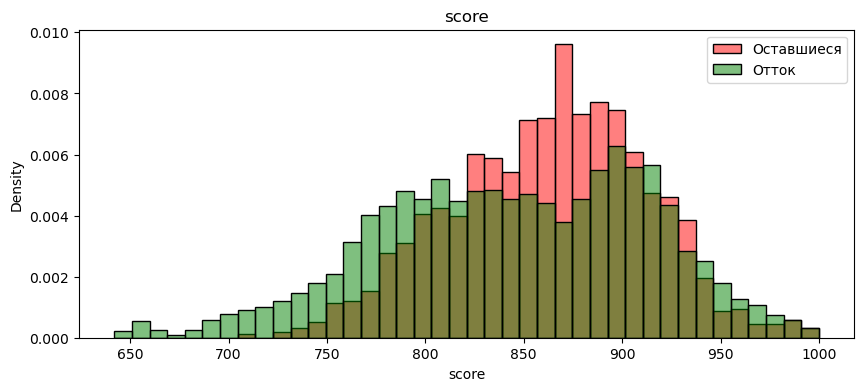

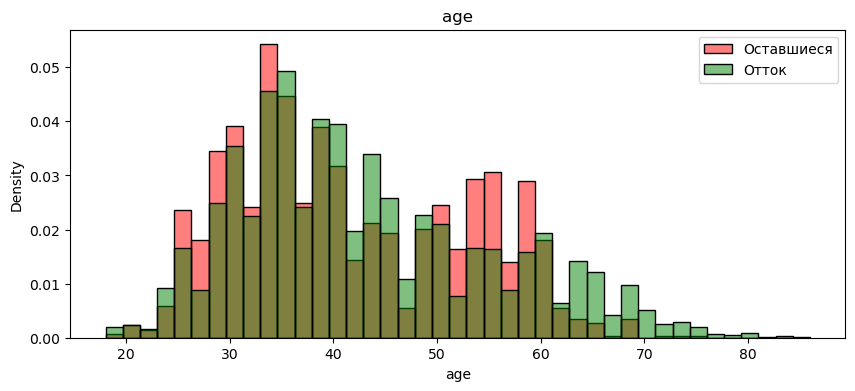

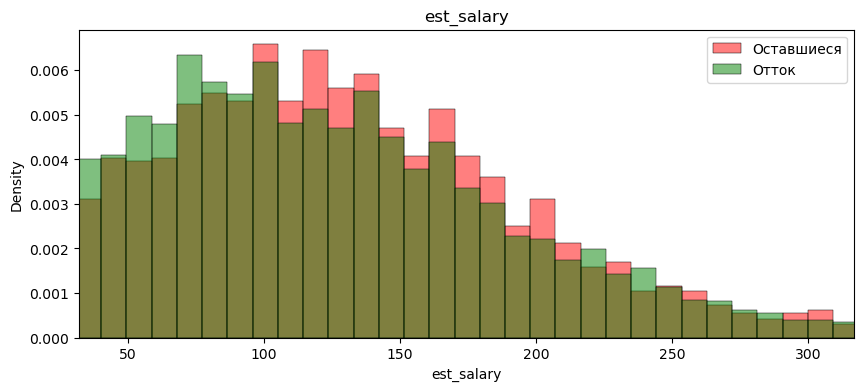

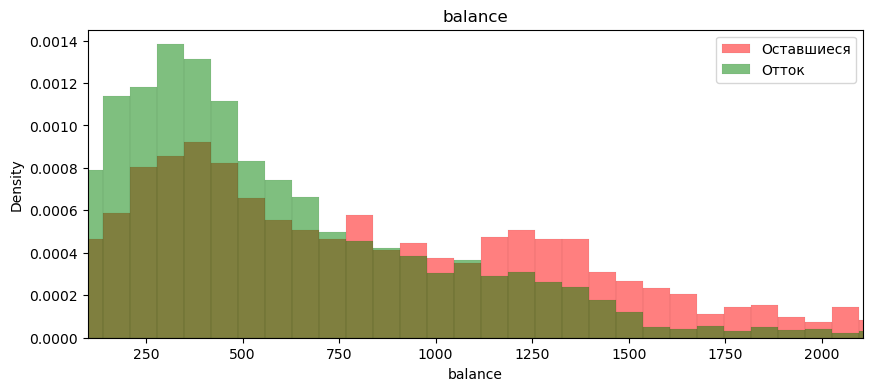

In [29]:
for column in distplot_columns:
    plt.figure(figsize=(10, 4))
    plt.title(column)
    if column in ['balance', 'est_salary']:
        # Настройка xlim для баланса и зарплаты для анализа основной части данных
        xlim_min = df[column].quantile(0.05)  # Нижний квантиль 5%
        xlim_max = df[column].quantile(0.95)  # Верхний квантиль 95%
        sns.histplot(data=df, x=column, hue='churn', palette={0: "green", 1: "red"}, stat="density", common_norm=False, alpha=0.5)
        plt.xlim(xlim_min, xlim_max)  # Установка xlim
    else:
        sns.histplot(data=df, x=column, hue='churn', palette={0: "green", 1: "red"}, stat="density", common_norm=False, alpha=0.5)
    plt.legend(labels=['Оставшиеся', 'Отток'])
    plt.show()

У столбцов 'balance' и 'est_salary' слишком много выбросов, построим ящик с усами для более детального анализа и попробуем устранить максимальные выбросы

Гистограммы по количественным признакам показывают, что:
 -	рейтинг особо не влияет на количество ушедших/оставшихся
 -	основной возраст ушедших незначительно моложе оставшихся и варьируется в районе 32
 -	большинство ушедших имели на остатке, меньшую сумму чем оставшиеся
 -	если брать доход то он по гистограмме примерно одинаков у оставшихся он незначительно выше.
  

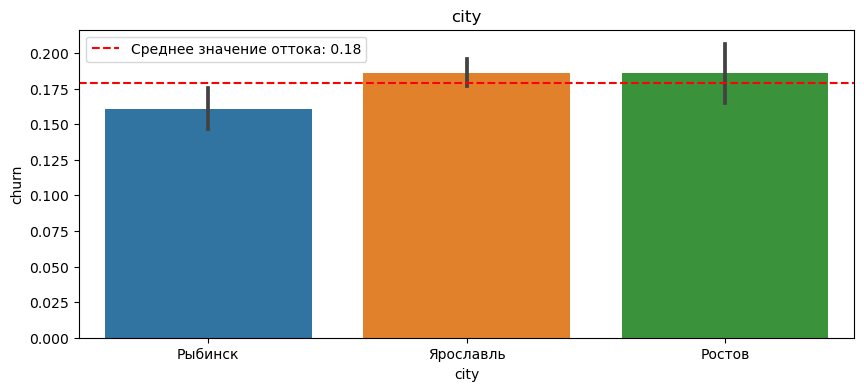

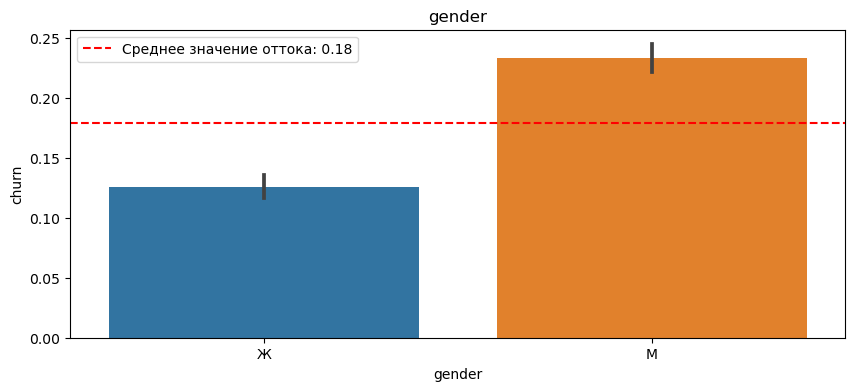

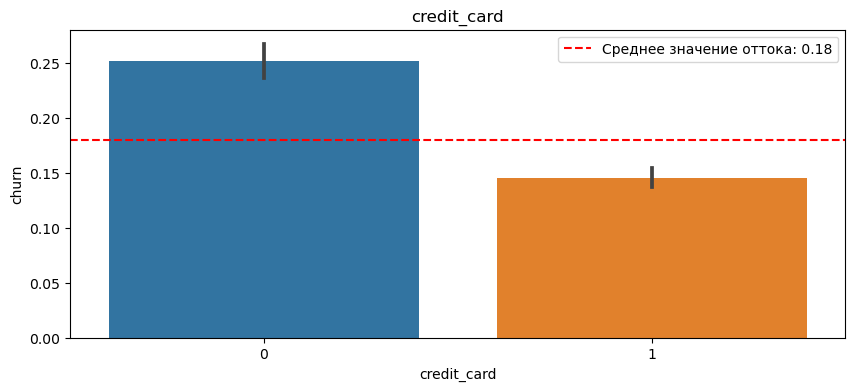

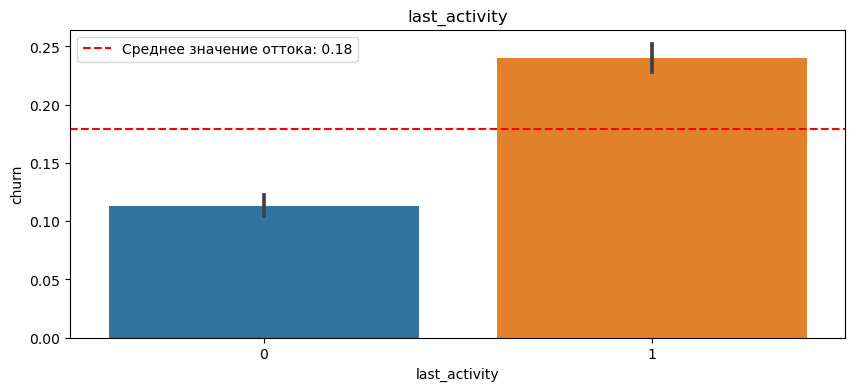

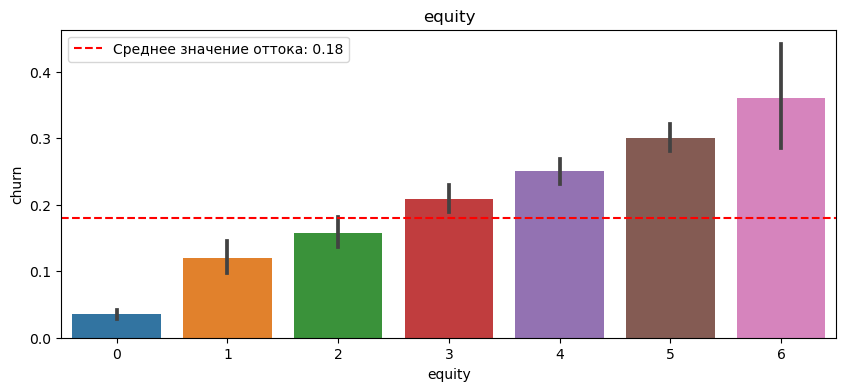

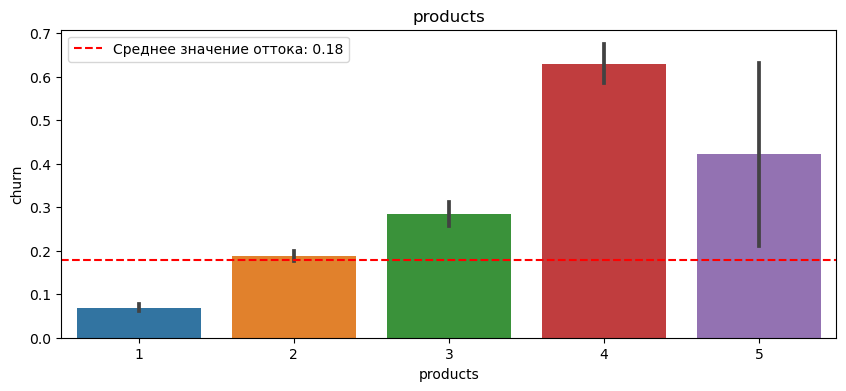

In [30]:
#Создание графика с помощью метода barplot()
distplot_columns1 = ['city', 'gender',  'credit_card', 'last_activity', 'equity', 'products']

for column in distplot_columns1:
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.barplot(x=column, y='churn', data=df)
    #Добавление горизонтальной линии для среднего значения оттока
    mean_churn = df['churn'].mean()
    plt.axhline(mean_churn, color='r', linestyle='--', label=f'Среднее значение оттока: {mean_churn:.2f}')
    plt.legend()
    plt.show()

Построив график по категориальным данным видно что большему оттоку подвержены в городах Ярославль и Ростов, также большему оттоку подвержены мужчины, клиенты не имеющие кредитные карты, и при этом более активные. Что касается наличие недвижимости в собственности, то тут видна прямая связь - чем больше объектов, тем выше отток у клиентов. По количеству продуктов схожая динамика, больший отток у клиентов с 3,4,5 продуктами.  

In [31]:
#Подготовим данные для построения матрицы корреляции методом phik, округлим результаты до двух знаков после запятой 
interval_cols = ['age', 'equity', 'est_salary', 'balance']
phik_overview = df.phik_matrix(interval_cols=interval_cols)
phik_overview.round(2)

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.00,0.12,0.09,0.14,0.53,0.54,0.38,0.17,0.00,0.56,0.20
city,0.12,1.00,0.01,0.09,0.06,0.04,0.13,0.08,0.03,0.17,0.02
gender,0.09,0.01,1.00,0.29,0.05,0.05,0.07,0.20,0.02,0.14,0.22
age,0.14,0.09,0.29,1.00,0.04,0.02,0.14,0.16,0.09,0.36,0.19
equity,0.53,0.06,0.05,0.04,1.00,0.00,0.41,0.16,0.03,0.22,0.25
balance,0.54,0.04,0.05,0.02,0.00,1.00,0.00,0.00,0.00,0.38,0.03
products,0.38,0.13,0.07,0.14,0.41,0.00,1.00,0.27,0.11,0.22,0.26
credit_card,0.17,0.08,0.20,0.16,0.16,0.00,0.27,1.00,0.05,0.04,0.20
last_activity,0.00,0.03,0.02,0.09,0.03,0.00,0.11,0.05,1.00,0.04,0.26
est_salary,0.56,0.17,0.14,0.36,0.22,0.38,0.22,0.04,0.04,1.00,0.05


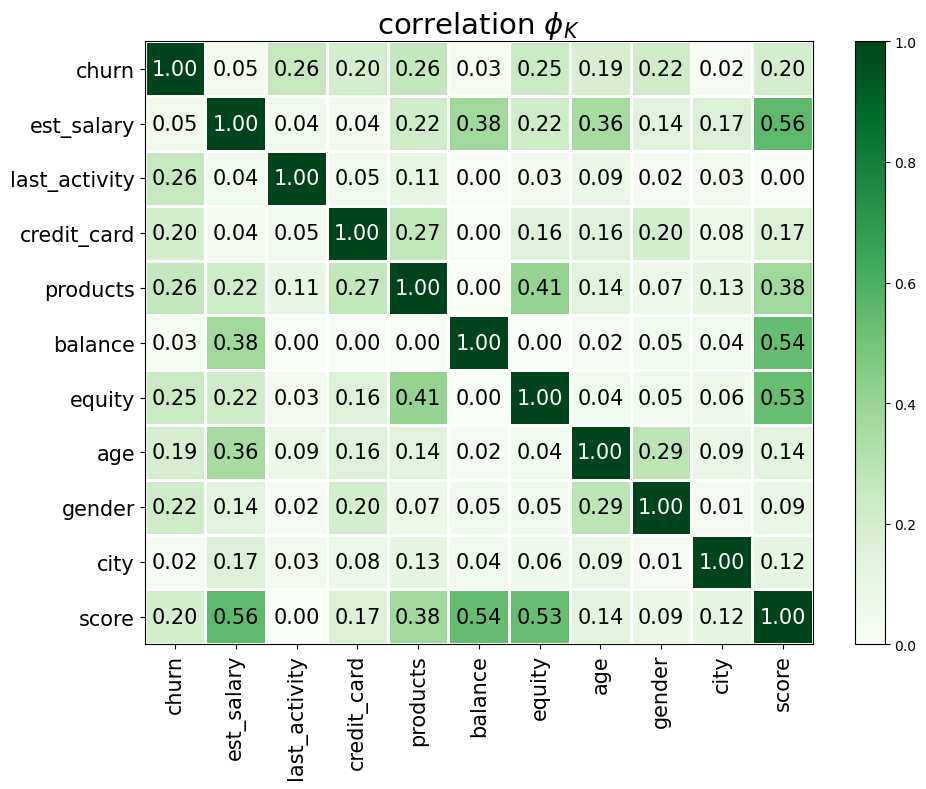

In [32]:
#построим матрицу корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

Построив матрицу корреляции стало видно что заметная связь есть между:
- 0.56 'est_salary' и 'score'
- 0.54 'balance' и 'score'
- 0.53 'equity' и 'score'

умеренная связь между:
- 0.41 'products' и 'equity'

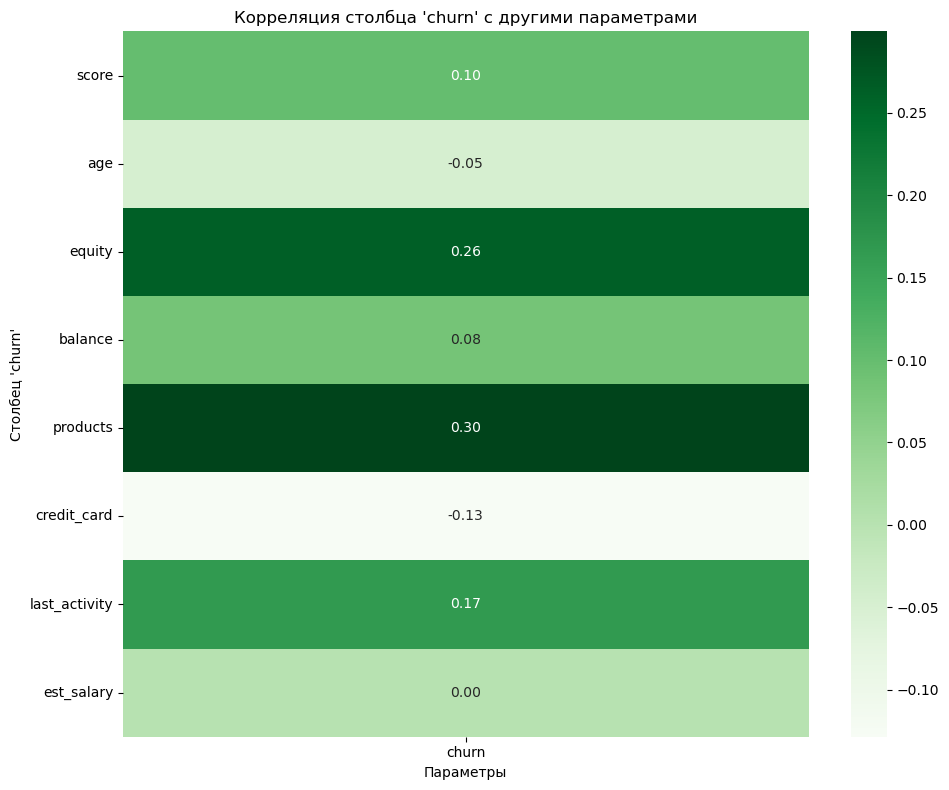

In [33]:
# Вычисление корреляций между 'churn' и всеми остальными столбцами
correlation_data = df.corr()['churn'].drop('churn')

# Построение матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.to_frame(), cmap='Greens', annot=True, fmt=".2f")
plt.title("Корреляция столбца 'churn' с другими параметрами")
plt.xlabel("Параметры")
plt.ylabel("Столбец 'churn'")
plt.tight_layout()
plt.show()

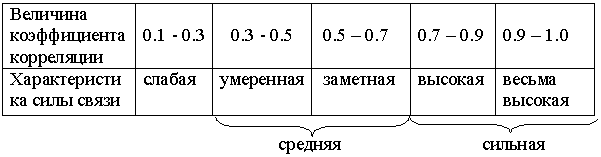


Сравним полученные значения корреляции праметра 'churn' с коэффициентом Чеддока:

- умеренная корреляция с параметром 'products'
- по остальным парраметрам корреляция слабая

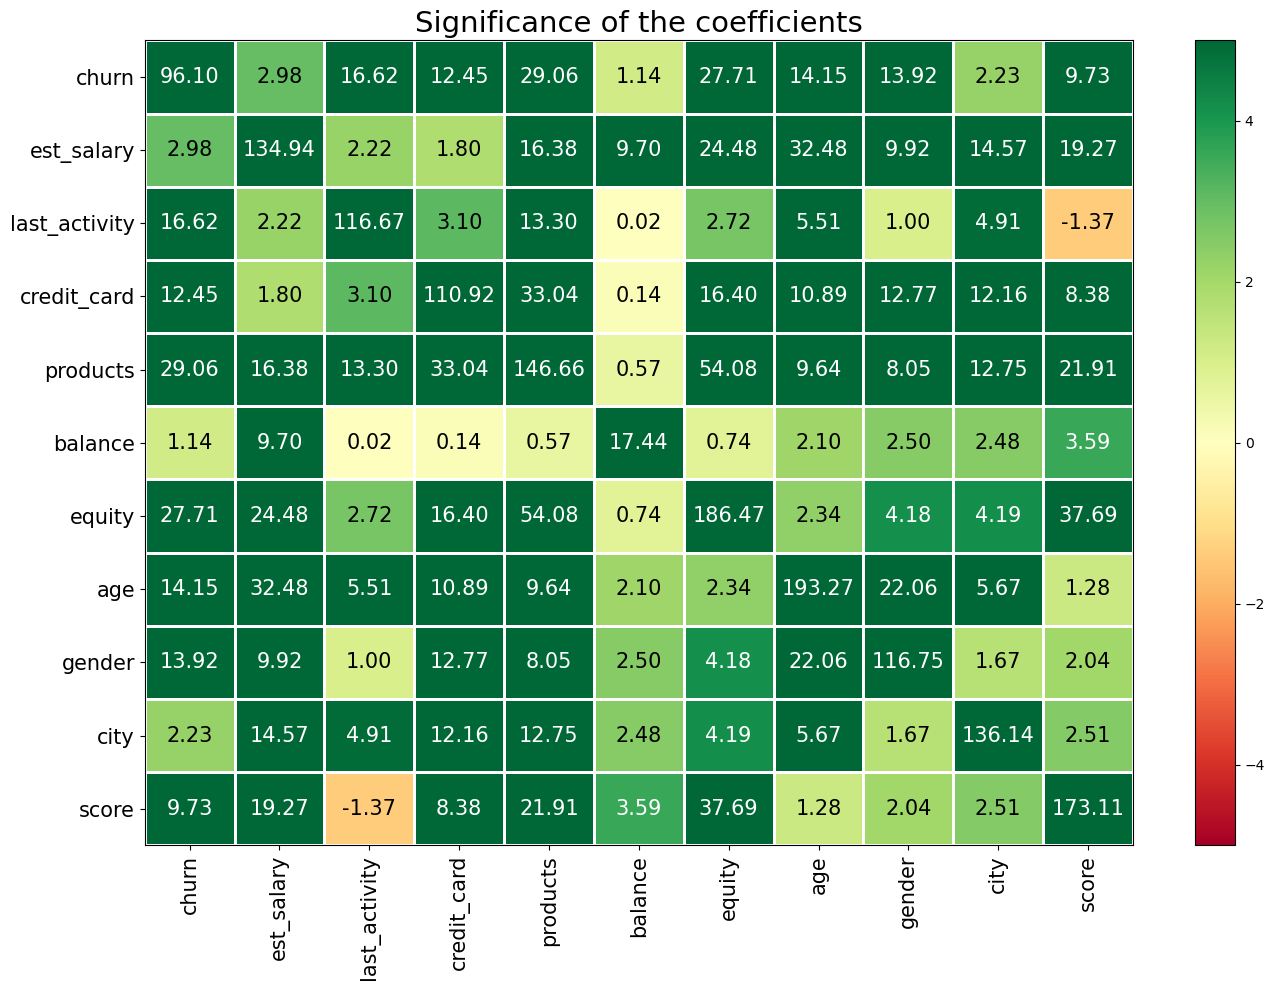

In [34]:
#проверим статистическую значимость корреляции
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10))
plt.tight_layout()

Если рассмотреть статистическую значимость, тут сохраняется такая же взаимосвязь характеристик, только более значимыми связями становятся  'products' и 'equity', 'equity' и 'score'

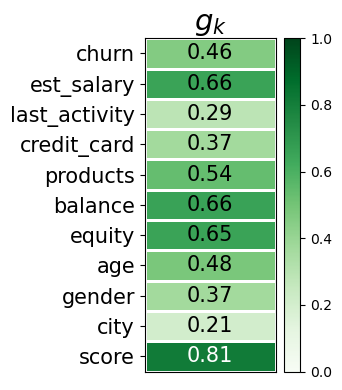

In [35]:
#глобальная корреляция
global_correlation, global_labels = df.global_phik(interval_cols=interval_cols)
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Определим портрет клиента, построив таблицу в разрезе оттока.

In [36]:
# Разделение данных на две группы: с оттоком и без оттока
df_churn = df[df['churn'] == 1]
df_no_churn = df[df['churn'] == 0]

# Создание пустого DataFrame для сохранения результатов
portrait_df = pd.DataFrame(columns=['Признак', 'Отток', 'Не отток', 'Относительная разница'])

# Средняя заплата
mean_salary_churn = df_churn['est_salary'].mean()
mean_salary_no_churn = df_no_churn['est_salary'].mean()
relative_diff_salary = mean_salary_churn - mean_salary_no_churn
portrait_df = portrait_df.append({'Признак': 'Средняя заплата', 'Отток': mean_salary_churn, 
                                  'Не отток': mean_salary_no_churn, 'Относительная разница': relative_diff_salary}, 
                                 ignore_index=True)

# Средний возраст
mean_age_churn = df_churn['age'].mean()
mean_age_no_churn = df_no_churn['age'].mean()
relative_diff_age = mean_age_churn - mean_age_no_churn
portrait_df = portrait_df.append({'Признак': 'Средний возраст', 'Отток': mean_age_churn, 
                                  'Не отток': mean_age_no_churn, 'Относительная разница': relative_diff_age}, 
                                 ignore_index=True)

# Средний баланс
mean_balance_churn = df_churn['balance'].mean()
mean_balance_no_churn = df_no_churn['balance'].mean()
relative_diff_balance = mean_balance_churn - mean_balance_no_churn
portrait_df = portrait_df.append({'Признак': 'Средний баланс', 'Отток': mean_balance_churn, 
                                  'Не отток': mean_balance_no_churn, 'Относительная разница': relative_diff_balance}, 
                                 ignore_index=True)

# Средний рейтинг
mean_score_churn = df_churn['score'].mean()
mean_score_no_churn = df_no_churn['score'].mean()
relative_diff_score = mean_score_churn - mean_score_no_churn
portrait_df = portrait_df.append({'Признак': 'Средний рейтинг', 'Отток': mean_score_churn, 
                                  'Не отток': mean_score_no_churn, 'Относительная разница': relative_diff_score}, 
                                 ignore_index=True)

# Медианное количество продуктов
median_products_churn = df_churn['products'].median()
median_products_no_churn = df_no_churn['products'].median()
relative_diff_products = median_products_churn - median_products_no_churn
portrait_df = portrait_df.append({'Признак': 'Медианное количество продуктов', 'Отток': median_products_churn, 
                                  'Не отток': median_products_no_churn, 'Относительная разница': relative_diff_products}, 
                                 ignore_index=True)

# Медианное количество собственности
median_assets_churn = df_churn['equity'].median()
median_assets_no_churn = df_no_churn['equity'].median()
relative_diff_assets = median_assets_churn - median_assets_no_churn
portrait_df = portrait_df.append({'Признак': 'Медианное количество собственности', 'Отток': median_assets_churn, 
                                  'Не отток': median_assets_no_churn, 'Относительная разница': relative_diff_assets}, 
                                 ignore_index=True)

# Мода по городу
mode_city_churn = df_churn['city'].mode()[0]
mode_city_no_churn = df_no_churn['city'].mode()[0]
portrait_df = portrait_df.append({'Признак': 'Мода по городу', 'Отток': mode_city_churn, 
                                  'Не отток': mode_city_no_churn, 'Относительная разница': ''}, ignore_index=True)

# Мода по полу
mode_gender_churn = df_churn['gender'].mode()[0]
mode_gender_no_churn = df_no_churn['gender'].mode()[0]
portrait_df = portrait_df.append({'Признак': 'Мода по полу', 'Отток': mode_gender_churn, 
                                  'Не отток': mode_gender_no_churn, 'Относительная разница': ''}, ignore_index=True)

# Мода по активности
mode_last_activity_churn = df_churn['last_activity'].mode()[0]
mode_last_activity_no_churn = df_no_churn['last_activity'].mode()[0]
portrait_df = portrait_df.append({'Признак': 'Мода по активности', 'Отток': mode_last_activity_churn, 
                                  'Не отток': mode_last_activity_no_churn, 'Относительная разница': ''}, ignore_index=True)

# Мода по кредитной карте
mode_credit_card_churn = df_churn['credit_card'].mode()[0]
mode_credit_card_no_churn = df_no_churn['credit_card'].mode()[0]
portrait_df = portrait_df.append({'Признак': 'Мода по кредитной карте', 'Отток': mode_credit_card_churn, 
                                  'Не отток': mode_credit_card_no_churn, 'Относительная разница': ''}, ignore_index=True)

# Вывод результата
portrait_df

C:\Users\123\AppData\Local\Temp\ipykernel_25400\4042249008.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portrait_df = portrait_df.append({'Признак': 'Средняя заплата', 'Отток': mean_salary_churn,
C:\Users\123\AppData\Local\Temp\ipykernel_25400\4042249008.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portrait_df = portrait_df.append({'Признак': 'Средний возраст', 'Отток': mean_age_churn,
C:\Users\123\AppData\Local\Temp\ipykernel_25400\4042249008.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  portrait_df = portrait_df.append({'Признак': 'Средний баланс', 'Отток': mean_balance_churn,
C:\Users\123\AppData\Local\Temp\ipykernel_25400\4042249008.py:36: FutureWarning: The frame.append method is deprecated and w

,Признак,Отток,Не отток,Относительная разница
0,Средняя заплата,148.61595,148.024954,0.590997
1,Средний возраст,41.51414,43.0063,-1.49216
2,Средний баланс,1133.973804,733.087665,400.886139
3,Средний рейтинг,862.680995,845.274861,17.406134
4,Медианное количество продуктов,2.0,2.0,0.0
5,Медианное количество собственности,4.0,2.0,2.0
6,Мода по городу,Ярославль,Ярославль,
7,Мода по полу,М,Ж,
8,Мода по активности,1,0,
9,Мода по кредитной карте,1,1,


Из таблицы видно что большему оттоку подвержены мужчины, имеющие в собственности 4 объекта недвижимости в возрасте около 41 года имеющие высокий баланс на карте. Зарплата, город, рейтинг, наличие кредитной карты  и количество продуктов которыми пользуется клиент на отток не влияют.

Из проведенного анализа можно сделать следующие выводы:
 - Основной возраст ушедших клиентов c медианным возрастом около 32 лет. 
 - Ушедшие клиенты имели на остатке большую сумму, чем оставшиеся, с медианным остатком около 800 по сравнению с 500 у оставшихся. 
 - Существует прямая связь между наличием недвижимости в собственности и количеством объектов недвижимости с оттоком клиентов. Чем больше объектов недвижимости и продуктов пользуется клиент, тем выше вероятность его ухода. 
 - Мужчины  более подверженными оттоку особенно в возрасте около 41 года, при этом в собственности много недвижимости и хороший остаток на карте

Корреляционные зависимости: Между финансовыми показателями (баланс, доход, недвижимость) и рейтингом клиента существует умеренная связь, что может указывать на их влияние на уход клиентов. Более значимые связи выявлены между количеством продуктов и наличием недвижимости в собственности, а также между рейтингом и наличием кредитной карты.

## Шаг 4. Проверка гипотез:

- Уровень дохода влияет на отток
- В городе 'Ярославль' отток в среднем выше
- Наличие(отсутствие) кредитной карты влияет на отток

Перед выбором метода проверки теста, рассмотрим насколько данные в столбцах распределены нормально

In [37]:
columns = ['churn','est_salary']
for column in columns:
    stat, p=stats.shapiro(data[column])
    print(f"Column:{column}, Statistic:{stat},p-value:{p}")
    if p>0.05:
        print(f"Не удалось отвергуть нулевую гипотезу: данные в столбце '{column}' распределены нормально")
    else:
        print(f"Нулевая гипотеза отвергнута, данные в столбце '{column}' не распределены  нормально")

Column:churn, Statistic:0.46555787324905396,p-value:0.0
Нулевая гипотеза отвергнута, данные в столбце 'churn' не распределены  нормально
Column:est_salary, Statistic:0.6196811199188232,p-value:0.0
Нулевая гипотеза отвергнута, данные в столбце 'est_salary' не распределены  нормально


C:\Users\123\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [38]:
# Вычисление дисперсии в столбце 'est_salary'
salary_variance = df['est_salary'].var()

print("Дисперсия в столбце 'est_salary':", salary_variance)

Дисперсия в столбце 'est_salary': 19475.98742819221


Данные не распределены нормально, поэтому мы не сможем в **Гипотезе 1** применить t-тест Стьюдента. Проверка дисперсии в est_salary говорит о больших разбросах в зарплатах, а ttest к этому так же чувствителен. Для этой гипотезы применим тест Манна-Уитни. Важно понимать, что тест Манна-Уитни не предполагает нормальное распределение данных и не чувствителен к выбросам, так как он работает с рангами значений, а не с их конкретными числовыми значениями. Это делает его полезным инструментом для анализа данных, где есть выбросы или данные не распределены нормально.

**Гипотеза 1.** Уровень дохода влияет на отток


Для проверки гипотезы о влиянии уровня дохода на отток с помощью теста Манна-Уитни можно сформулировать нулевую и альтернативную гипотезы следующим образом:

 - Нулевая гипотеза (H0): Средние значения уровня дохода одинаковы для клиентов с оттоком и без оттока.
 - Альтернативная гипотеза (H1): Средние значения уровня дохода различаются для клиентов с оттоком и без оттока.


In [39]:
#Разделяем данные на две группы: с оттоком и без оттока 
group_churn_0 = df[df['churn'] == 0]['est_salary'] 
group_churn_1 = df[df['churn'] == 1]['est_salary'] 

#Выполняем тест Манна-Уитни 
stat, p_value = mannwhitneyu(group_churn_0, group_churn_1) 

#Выводим результаты 
print(f"Mann-Whitney U statistic: {stat}") 
print(f"P-value: {p_value}") 
alpha = 0.05 
if p_value < alpha: 
    print("Отвергаем нулевую гипотезу: Средние значения уровня дохода различаются для клиентов с оттоком и без оттока.") 
else: 
    print("Не отвергаем нулевую гипотезу: Средние значения уровня дохода одинаковы для клиентов с оттоком и без оттока.")

Mann-Whitney U statistic: 6742634.5
P-value: 0.00013844156995491922
Отвергаем нулевую гипотезу: Средние значения уровня дохода различаются для клиентов с оттоком и без оттока.


**Гипотеза 2.** В городе 'Ярославль' отток в среднем выше

Для проверки гипотезы о влиянии города на отток применим  Z-тест для разности пропорций. Такой тест лучше всего применять для бинарных признаков (например, наличие/отсутствие кредитной карты), потому что он предназначен для сравнения долей или пропорций в двух независимых выборках, в которых каждая наблюдение может принимать только одно из двух возможных значений.
Сформулируем нулевую и альтернативную гипотезы следующим образом:

- Нулевая гипотеза (H0): Средние значения оттока одинаковы для клиентов из городов 'Ярославль' и остальных городов.
- Альтернативная гипотеза (H1): Средние значения оттока различаются для клиентов из городов 'Ярославль' и остальных городов.


In [40]:
# Создание бинарного признака для города Ярославль
df['is_yaroslavl'] = (df['city'] == 'Ярославль').astype(int)

# Выполнение Z-теста для проверки различий в пропорциях оттока
count_yaroslavl = df[df['is_yaroslavl'] == 1]['churn'].sum()
count_other_cities = df[df['is_yaroslavl'] == 0]['churn'].sum()

nobs_yaroslavl = df['is_yaroslavl'].sum()
nobs_other_cities = len(df) - nobs_yaroslavl

stat, p_value = proportions_ztest([count_yaroslavl, count_other_cities], [nobs_yaroslavl, nobs_other_cities])

# Анализ p-значения
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: пропорции оттока различаются для клиентов из города 'Ярославль' и остальных городов.")
else:
    print("Не отвергаем нулевую гипотезу: пропорции оттока одинаковы для клиентов из города 'Ярославль' и остальных городов.")

Отвергаем нулевую гипотезу: пропорции оттока различаются для клиентов из города 'Ярославль' и остальных городов.


**Гипотеза 3.** Наличие(отсутствие) кредитной карты влияет на отток


Для проверки гипотезы о влиянии города на отток применим  Z-тест для разности пропорций. Такой тест лучше всего применять для бинарных признаков (например, наличие/отсутствие кредитной карты), потому что он предназначен для сравнения долей или пропорций в двух независимых выборках, в которых каждая наблюдение может принимать только одно из двух возможных значений.
Можно сформулировать нулевую и альтернативную гипотезы следующим образом:

 - Нулевая гипотеза (H0): Доли оттока одинаковы для клиентов с кредитной картой и без кредитной карты.
 - Альтернативная гипотеза (H1): Доли оттока различаются для клиентов с кредитной картой и без кредитной карты.


In [41]:
# Выборки
group_credit_card_1 = df[df['credit_card'] == 1]['churn'] 
group_credit_card_0 = df[df['credit_card'] == 0]['churn'] 

# z-тест для сравнения пропорций двух групп
count = [group_credit_card_1.sum(), group_credit_card_0.sum()]  # количество случаев оттока в каждой группе
nobs = [len(group_credit_card_1), len(group_credit_card_0)]  # общее количество наблюдений в каждой группе

# proportions_ztest возвращает z-score и p-value
z_score, p_value = proportions_ztest(count, nobs)

# Вывод результатов
print(f"z-статистика: {z_score}")
print(f"p-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Доли оттока различаются для клиентов с кредитной картой и без кредитной карты.")
else:
    print("Не отвергаем нулевую гипотезу: Доли оттока одинаковы для клиентов с кредитной картой и без кредитной карты.")

z-статистика: -12.777484938776302
p-значение: 2.190386044720369e-37
Отвергаем нулевую гипотезу: Доли оттока различаются для клиентов с кредитной картой и без кредитной карты.


**Вывод** 
Гипотеза №1 - Уровень дохода оказывает влияние на отток клиентов. Исходя из результатов теста Манна-Уитни для сравнения уровня дохода среди клиентов с оттоком и клиентов без оттока, мы отвергаем нулевую гипотезу о том, что средние значения уровня дохода одинаковы для этих двух групп. Это означает, что есть статистически значимые различия в уровне дохода между клиентами с оттоком и клиентами без оттока.

Гипотеза №2 - В городе 'Ярославль' отток в среднем выше. Исходя из результатов Z-тест для разности пропорций сравнения оттока среди клиентов из города 'Ярославль' и клиентов из остальных городов, мы отвергаем нулевую гипотезу о том, что средние значения оттока одинаковы для этих двух групп. Это означает, что есть статистически значимые различия в оттоке между клиентами из города 'Ярославль' и клиентами из других городов.

Гипотеза №3 - Доли оттока различаются для клиентов с кредитной картой и без кредитной карты. На основании проведенного Z-теста для разности пропорций, мы отвергаем нулевую гипотезу о равенстве долей оттока для клиентов с кредитной картой и без кредитной карты (p-значение < 0.05). Это означает, что наличие или отсутствие кредитной карты влияет на вероятность оттока клиентов. Таким образом, можно предположить, что наличие кредитной карты может быть связано с меньшей вероятностью оттока клиентов, чем отсутствие кредитной карты.

## Шаг 5. Проведем сегментацию пользователей

Чтобы определить с какмими сегментами будем работать определим основные условия:
 - уровень оттока в сегменте выше среднебанковского
 - каждый сегмент должен включать не менее 500 клиентов.
 
Для построение сегментов возьмем за основу EDA в разрезе оттока, проведенный ранее 

In [42]:
def segment_clients(row):
    if row['score'] > 900 and row['age'] <40:
        return 'Молодой возраст с высоким рейтингом'
    elif row['balance'] >800 and row['est_salary'] >1000:
        return 'Высокий баланс и доход'
    elif row['city'] == 'Ярославль' and row['gender'] == 'М' and row['score'] >862:
        return 'Мужчины Ярославля с высоким рейтингом'
    elif row['city'] == 'Ростов' and row['credit_card'] == 0 :
        return 'Мужчины Ростова  без кредитной карты'
    elif row['credit_card'] ==0 and row['last_activity'] == 1:
        return 'Активный клиент без кредитной карты'
    elif row['products'] >= 3 and row['equity'] >= 3:
        return 'Много продуктов и много недвижимости'
    else:
        return 'Другие сегменты'

# Применяем функцию к каждой строке DataFrame 
df['segment'] = df.apply(segment_clients, axis=1)

In [43]:
# Создаем сводную таблицу с количеством клиентов и оттоком в каждом сегменте
pivot_table = pd.pivot_table(df, index='segment', values='churn', aggfunc=['count', 'mean'])

# Переименуем столбцы для ясности
pivot_table.columns = ['Количество клиентов', 'Доля оттока']

# Округляем до двух знаков после запятой и сортируем по столбцу 'Доля оттока' в порядке убывания
pivot_table['Доля оттока'] = (pivot_table['Доля оттока'] * 100).round(2)  
pivot_table = pivot_table.sort_values(by='Доля оттока', ascending=False)  

pivot_table

,Количество клиентов,Доля оттока
segment,,
Много продуктов и много недвижимости,616,33.12
Активный клиент без кредитной карты,1082,31.61
Мужчины Ярославля с высоким рейтингом,949,26.77
Мужчины Ростова без кредитной карты,564,21.10
Молодой возраст с высоким рейтингом,1159,20.79
Высокий баланс и доход,5,20.00
Другие сегменты,5488,11.06


In [44]:
df['churn'].mean()

0.17925580452195072

Итак условиям для выбора сегмента соответсвуют 4 сегмента: 'Много продуктов и много недвижимости', 'Активный клиент без кредитной карты', 'Молодой возраст с высоким рейтингом', 'Мужчины Ярославля с высоким рейтингом'.

Создадим новый DF который будет содержать данные только по выбранным сегментам, заранее не будем включать туда столбец 'gender' чтобы не дублировать имеющую информацию, и 'balance' по причине большого количества пропусков, что может не правильно интерпретировать анализ.

In [45]:
# Создаем новый DataFrame, содержащий только данные по выбранным сегментам
selected_segments = df.query("segment in ['Много продуктов и много недвижимости', \
                                      'Молодой возраст с высоким рейтингом', \
                                      'Активный клиент без кредитной карты', \
                                      'Мужчины Ярославля с высоким рейтингом']")
selected_segments.head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,is_yaroslavl,segment
0,850.0,Рыбинск,Ж,25.0,1,59.0,2,0,1,76.0,1,0,Активный клиент без кредитной карты
1,861.0,Рыбинск,Ж,37.0,5,851.0,3,1,0,87.0,0,0,Много продуктов и много недвижимости
3,866.0,Ярославль,Ж,51.0,5,1525.0,2,0,1,174.0,1,1,Активный клиент без кредитной карты
5,856.0,Рыбинск,М,56.0,4,864.0,3,1,0,157.0,0,0,Много продуктов и много недвижимости
6,807.0,Ярославль,Ж,39.0,3,405.0,3,0,1,104.0,0,1,Активный клиент без кредитной карты


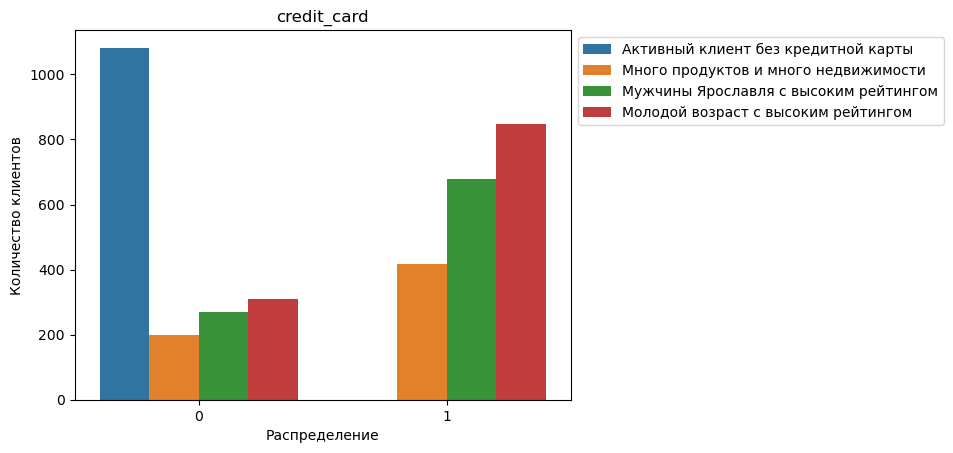

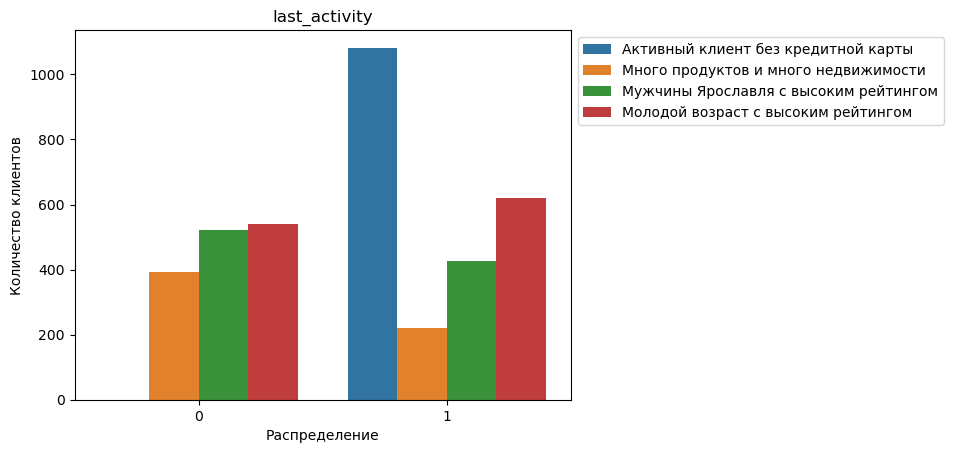

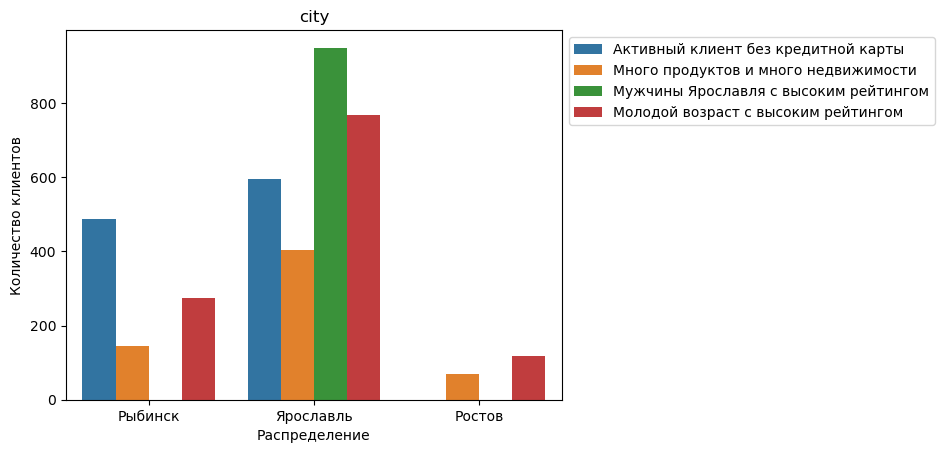

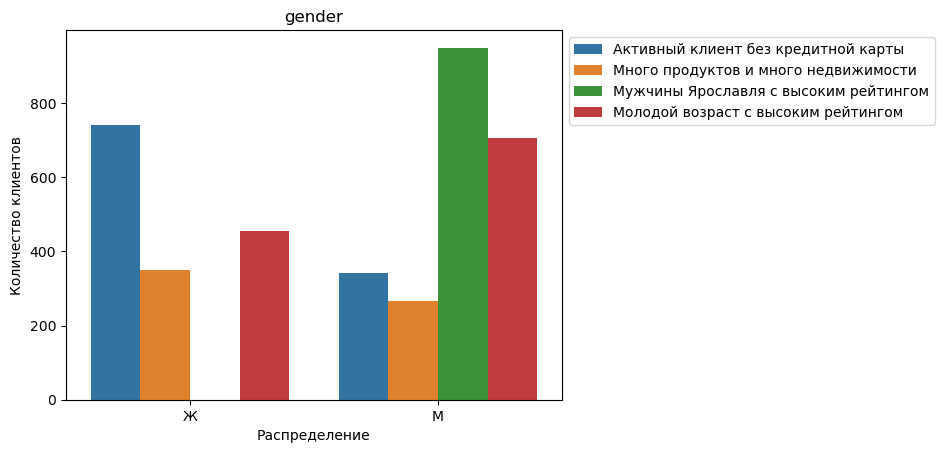

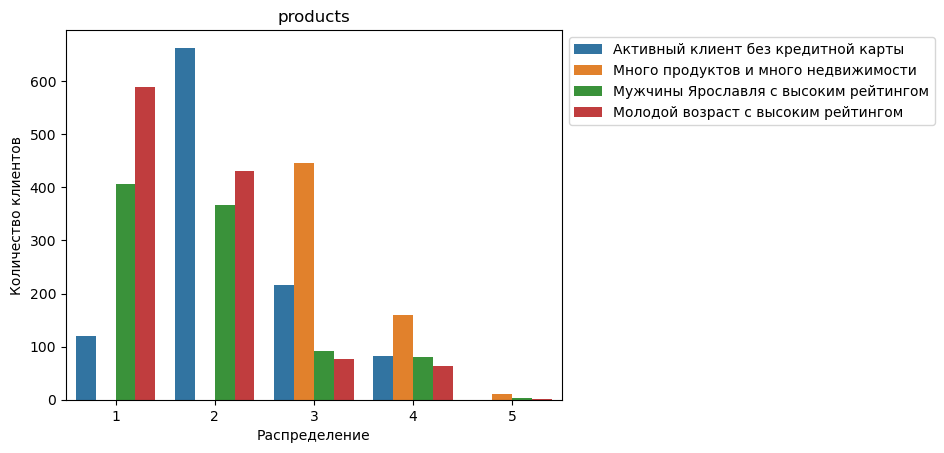

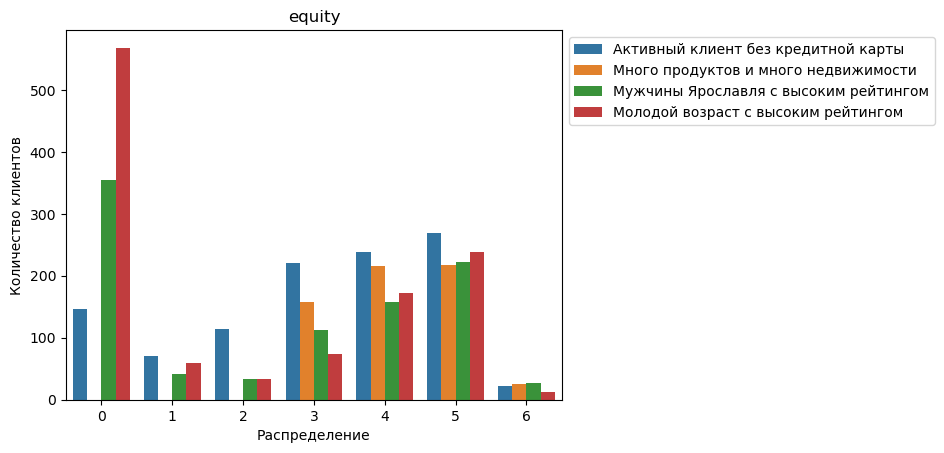

In [46]:
#строим график распределения по каждому сегменту
values = ['credit_card', 'last_activity', 'city','gender', 'products', 'equity']
fig, ax = plt.subplots()

for column in values:
    plt.title(column)
    sns.countplot(data=selected_segments, x=column, hue='segment')
    plt.xlabel('Распределение')
    plt.ylabel('Количество клиентов')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()  

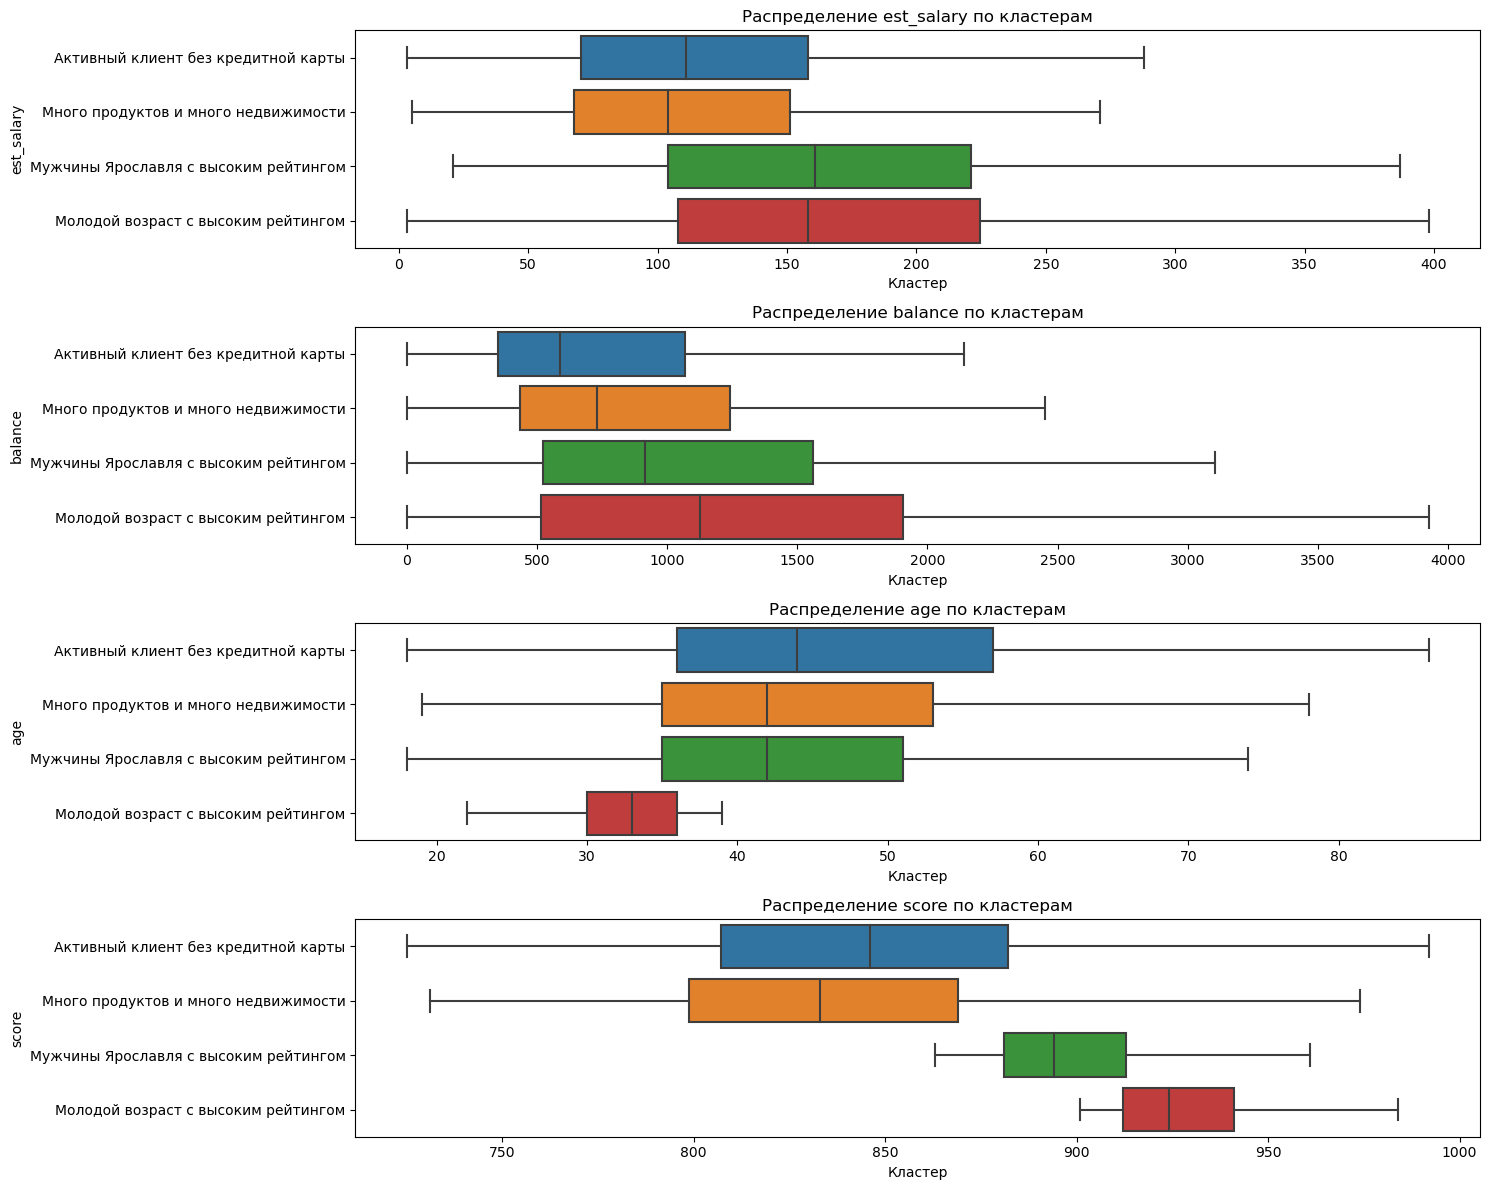

In [47]:
#построим ящик с усами 
values = ['est_salary', 'balance','age', 'score']
fig, axes = plt.subplots(nrows=len(values), ncols=1, figsize=(15, 12))

for i, column in enumerate(values):
    sns.boxplot(data=selected_segments, y='segment', x=column, ax=axes[i], showfliers=False)
    axes[i].set_title(f'Распределение {column} по кластерам')
    axes[i].set_xlabel('Кластер')
    axes[i].set_ylabel(column)
plt.tight_layout()
plt.show()

На основе полученных графиков распишем основные харрактеристики клиентов в зависимости от сегмента. 

Сегмент 1: Много продуктов и много недвижимости
- Доля оттока 33% 
- численность сегмента 616
- город обслуживания в основном Ярославль 
- у большинства есть кредитная карта
- не очень активные, средний баланс
- в основном женщины в возрасте 43 года
- с более низкой зарплатной чем по остальным сегментам с самым низким рейтингом

Сегмент 2: Активный клиент без кредитной карты
- Доля оттока 31%
- численность сегмента 1082
- город обслуживания  Ярославль и Рыбинск 
- в большинстве женщины в возрасте 45 лет
- пользующиеся 2-мя продуктами
- в среднем 4 объекта недвижимости
- средняя зарплата по сегменту низкая
- рейтинг не высокий, баланс низкий


Сегмент 3: Мужчины Ярославля с высоким рейтингом
- Доля оттока 26%
- численность сегмента 949
- большинство используют кредитную карту
- большинство не активные, возраст 45
- пользуются в основном 1-2 продуктами 
- у большинства нет недвижимости
- самая высокая зарплата по сегментам в медианном значении
- баланс выше среднего

Сегмент 4: Молодой возраст с высоким рейтингом
- Доля оттока 20% 
- численность сегмента 1159
- у большинства есть кредитная карта
- в основном мужчины, активные
- составляет значительную часть клиентов Ярославля
- пользуются в основном 1-2 продуктами
- недвижимости в собственности у большинства либо нет, либо очень много
- зарплата выше среднего по сегментам, баланс выше чем у остальных




## Выводы и рекомендации

Нами были изучены и проанализированны данные клиентов "Метанпромбанк". 
привели название столбцов к нижнему регистру, проверили пропуски и дубликаты. В столбце 'user_id' Были дубликаты которые пересекались с пропусками в столбце 'age', таких пропусков было меньше 1%, поэтому мы их удалили. Рассмотрели уникальные значения в столбце 'products' и 'equity' были незначительные выбросы в данных скорей всего либо клиента еще полностью не оформили, либо ошибка в данных, мы так же удалили эти строки. 
Далее приняли решение создать копию DF без столбца user_id, для удобного анализа. В столбце 'balance' много пропущенных значений, заменить на 0 не получилось, потому что такая информация есть в столбце. Проверили на наличие дубликатов - не выявлено. 

Из проведенного анализа EDA для банка можно сделать следующие выводы:
- Возраст: Основной возраст ушедших клиентов незначительно моложе, с медианным возрастом около 32 лет. Это может указывать на то, что молодые клиенты склонны к уходу из банка чаще, возможно, из-за изменения потребностей или более активной конкуренции на рынке.
- Финансовые показатели: Ушедшие клиенты имели на остатке большую сумму, чем оставшиеся, с медианным остатком около 800 по сравнению с 500 у оставшихся. Это может указывать на то, что клиенты с более высоким балансом могут уходить из-за недовольства услугами или поиска более выгодных предложений в других банках.
- Недвижимость и количество продуктов: Существует прямая связь между наличием недвижимости в собственности и количеством объектов недвижимости с оттоком клиентов. Чем больше объектов недвижимости и продуктов пользуется клиент, тем выше вероятность его ухода. Возможно, это связано с изменением жизненной ситуации или неудовлетворенностью текущими услугами банка.
- Мужчины и отток: Мужчины являются более подверженными оттоку клиентами, особенно в возрасте около 41 года, имеющие в собственности 4 объекта недвижимости и с высоким балансом на карте. Это может быть важным показателем для разработки стратегий удержания клиентов и предложения персонализированных услуг для этой группы.
- Корреляционные зависимости: Между финансовыми показателями (баланс, доход, недвижимость) и рейтингом клиента существует умеренная связь, что может указывать на их влияние на уход клиентов. Более значимые связи выявлены между количеством продуктов и наличием недвижимости в собственности, а также между рейтингом и наличием кредитной карты.


Были выдвинуты и проверены 3 гипотезы:

 - Гипотеза №1 - Уровень дохода оказывает влияние на отток клиентов. Исходя из результатов теста Манна-Уитни для сравнения уровня дохода среди клиентов с оттоком и клиентов без оттока, мы отвергаем нулевую гипотезу о том, что средние значения уровня дохода одинаковы для этих двух групп. Это означает, что есть статистически значимые различия в уровне дохода между клиентами с оттоком и клиентами без оттока.
 - Гипотеза №2 - В городе 'Ярославль' отток в среднем выше. Исходя из результатов теста Манна-Уитни для сравнения оттока среди клиентов из города 'Ярославль' и клиентов из остальных городов, мы отвергаем нулевую гипотезу о том, что средние значения оттока одинаковы для этих двух групп. Это означает, что есть статистически значимые различия в оттоке между клиентами из города 'Ярославль' и клиентами из других городов.
 - Гипотеза №3 - Средние значения оттока различаются для клиентов с кредитной картой и без кредитной карты. Исходя из результатов теста Стьюдента (t-теста) для сравнения оттока среди клиентов с кредитной картой и клиентов без кредитной карты, мы отвергаем нулевую гипотезу о том, что средние значения оттока одинаковы для этих двух групп. Это означает, что есть статистически значимые различия в оттоке между клиентами с кредитной картой и клиентами без кредитной карты. 

Далее была проведена сигментация клиентов, было выделено 4 сегмента, каждый из них описывает портрет клиента, на основе этого была составлена таблица характеристика на каждый сегмент. На основе представленных данных можно дать следующие рекомендации

`1:Много продуктов и много недвижимости`
Это клиенты в возрасте, имея много недвижимости, при этом официально низкий доход, можно предположить что живут на доход от ренты. Можно предложить интересные условия по вкладам, с процентом на остаток. Так же возможно предложение страхования недвижимости, если данная услуга есть в банке. Так как клиенты в основном женщины среднего возраста, скорей всего семейные, можно заинтересовать картами с повышенным кэшбэком

`2: Активный клиент без кредитной карты`
Привлечение кредитных карт.Проведите кампанию по привлечению клиентов данного сегмента к использованию кредитных карт, предлагая им выгодные условия и привилегии, такие как бесплатное обслуживание или кэшбэк за покупки.
Бонусные программы: Запустите бонусные программы и акции для клиентов данного сегмента, стимулируя их активность и повышая лояльность к банку, например, предложив бонусы за рекомендации друзьям или за использование дополнительных продуктов банка.

`3: Мужчины Ярославля с высоким рейтингом`
Разработайте специальные эксклюзивные предложения и услуги для мужчин данного сегмента с высоким рейтингом, например, предложите им доступ к премиальным банковским продуктам или VIP-сервису.
Предложить индивидуальные решения и консультации по финансовым вопросам, включая планирование инвестиций и управление финансами.
Можно предложить интересные условия по вкладам, с процентом на остаток, так как остаток на счете в этом сегменте максимальный.

`4: Молодой возраст с высоким рейтингом`
Предложите молодым клиентам с высоким рейтингом персонализированные финансовые услуги и продукты, учитывая их специфические потребности и цели, такие как ипотечное кредитование или инвестиционные решения.
Организуйте образовательные мероприятия и программы по повышению финансовой грамотности для молодых клиентов данного сегмента, помогая им освоить навыки управления финансами и принимать информированные решения.
Разработайте цифровые решения и интерактивные инструменты для молодых клиентов, облегчающие управление финансами и предоставляющие им доступ к инновационным банковским услугам через мобильные приложения и онлайн-платформы.


# Материалы
*[Презентация]: https://drive.google.com/file/d/13JwdRAODZJcoomniplL7-Xv_SPu_HS3c/view?usp=sharing